USING ARIMA MODEL TO PREDICT FUTURE SALES OF CATFISH


In [8]:
# Importing Libraries
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta


In [9]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [11]:
# Importing Catfish data set
# Making the date column as index
df = pd.read_csv('catfish.csv',parse_dates=[0], index_col=0, date_parser=parser)
df

<ipython-input-11-88165348847c>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('catfish.csv',parse_dates=[0], index_col=0, date_parser=parser)


,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239
...,...
2012-08-01,14442
2012-09-01,13422
2012-10-01,13795


In [12]:
# Adjusting the frquencies of the time series base on the index
df = df.asfreq(pd.infer_freq(df.index))

In [13]:
# Getting Information on the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 324 entries, 1986-01-01 to 2012-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Total   324 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


<Axes: xlabel='Date'>

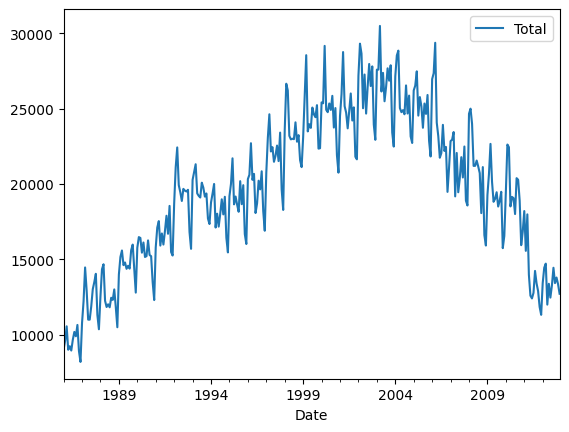

In [14]:
#Ploting the sales over years
df.plot()

<Axes: xlabel='Date'>

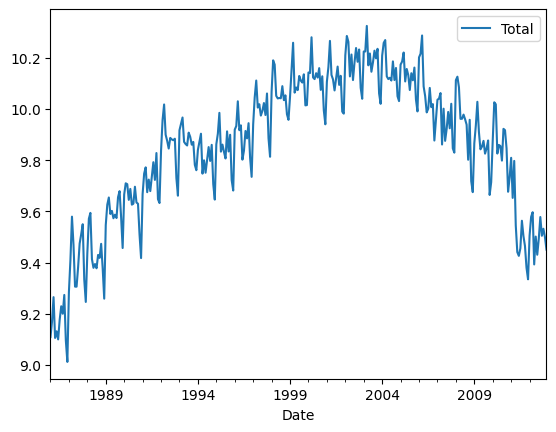

In [15]:
# Using log to transform series to stabilize its variance
df = np.log(df)
df.plot()

Checking Staionarity of the time series data

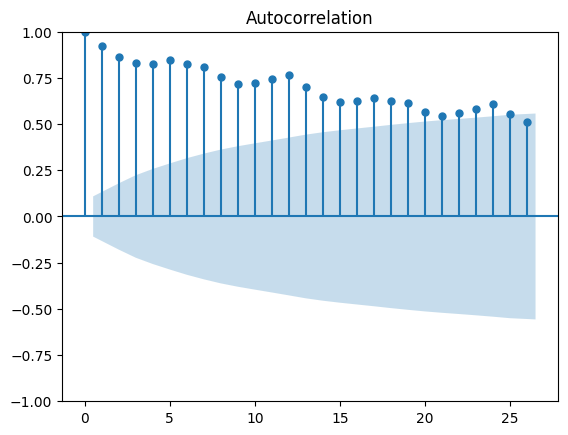

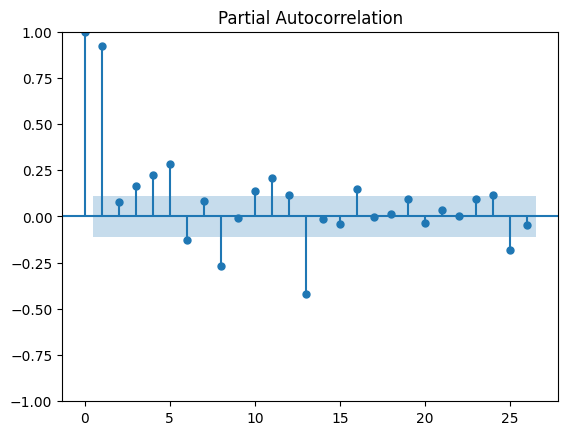

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df)

pacf_original = plot_pacf(df)

In [18]:
# Using the ADF test to  get the p-value of the data
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df)
print(f'p-value: {adf_test[1]}')

# p-value is extremely large (0.41505) the test value rejects the null hypothesis

p-value: 0.4150574346199324


Transforming Non-Stationary into Stationary Using Differencing

<Axes: xlabel='Date'>

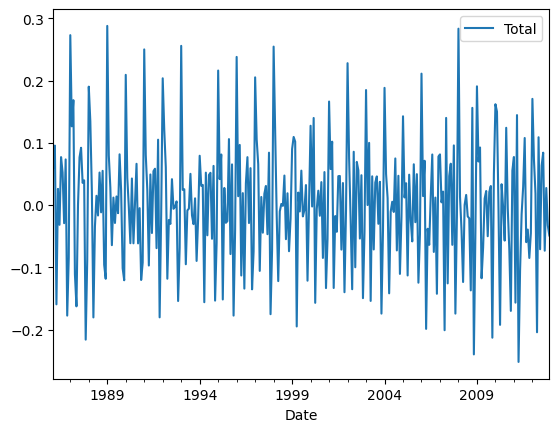

In [19]:
# First Order differencing
df = df.diff().dropna()
df.plot()

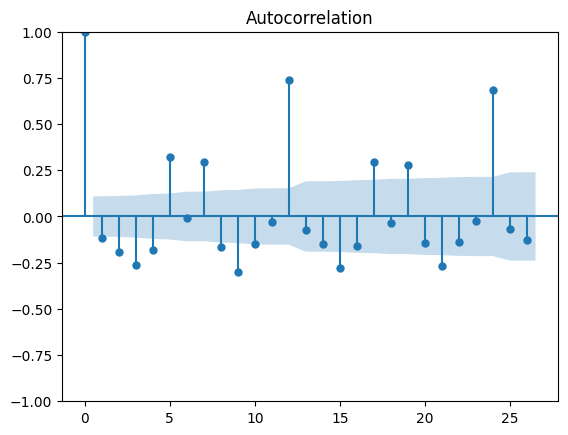

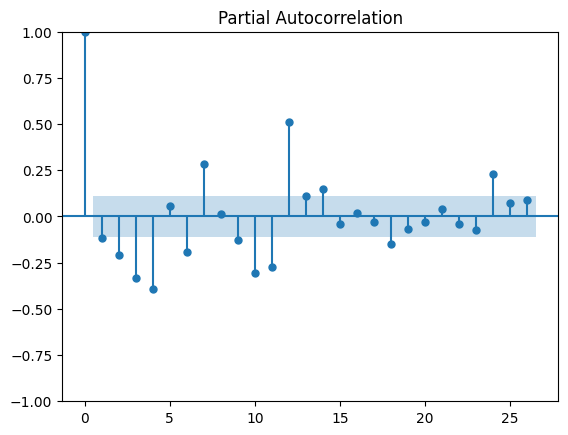

In [20]:
# Ploting the ACF and PACF after the first difference
acf_diff_first = plot_acf(df)

pacf_diff_first = plot_pacf(df)

In [21]:
# # Using the ADF test to  get the p-value of the data after the first diference
adf_test = adfuller(df)
print(f'p-value: {adf_test[1]}')
# P-value is less then 5%

p-value: 0.00021518538273796953


Getting the training and test set

In [22]:
#Spliting the Data into training and test data
train_end = datetime(2003,7,1)
test_end = datetime(2004,1,1)

train_data = df[:train_end]
test_data = df[train_end + timedelta(days=1):test_end]

Fitting the ARMA Model

In [23]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df, order=(4,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  323
Model:                 ARIMA(4, 1, 0)   Log Likelihood                 277.811
Date:                Tue, 21 Jan 2025   AIC                           -545.623
Time:                        12:36:04   BIC                           -526.750
Sample:                    02-01-1986   HQIC                          -538.088
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8260      0.057    -14.506      0.000      -0.938      -0.714
ar.L2         -0.6857      0.061    -11.315      0.000      -0.804      -0.567
ar.L3         -0.6443      0.064    -10.075      0.0

In [34]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.2103595733642578


Make time series predictions

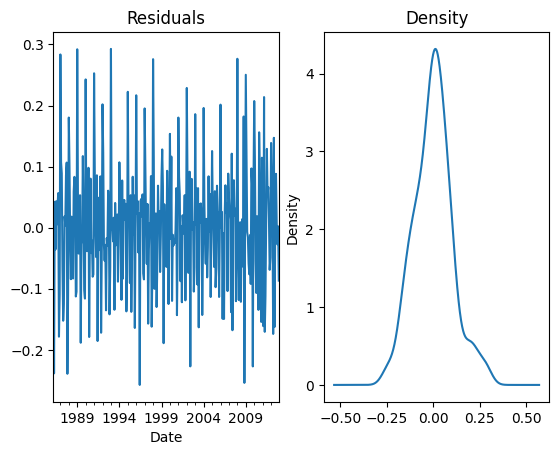

In [24]:
# Checking white noise in model
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

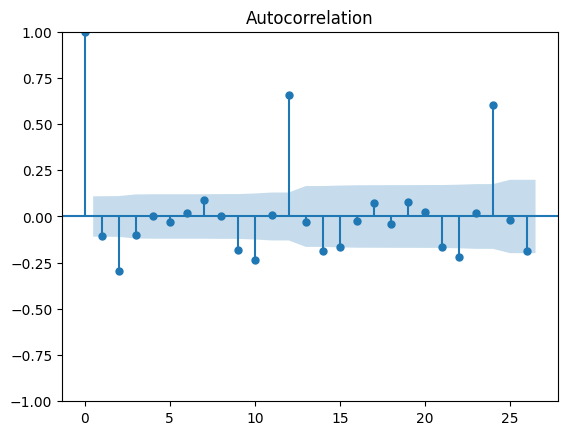

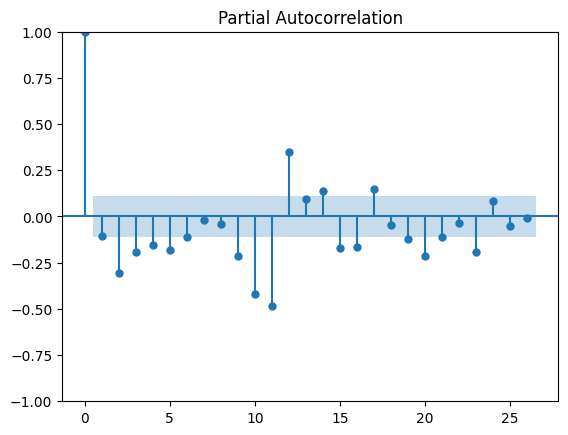

In [25]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

In [27]:
#Importing Libraries
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from time import time

In [28]:
# Working on test data for prediction
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [29]:
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

Text(0, 0.5, 'Sales')

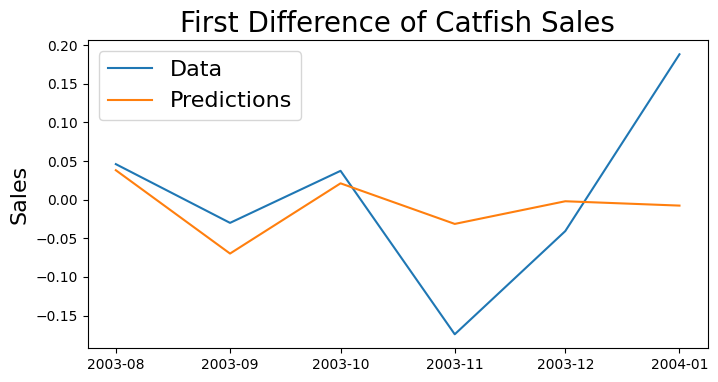

In [33]:
plt.figure(figsize=(8,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)